In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as layers
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
import keras_tuner as kt

In [10]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [11]:
X_train.shape

(60000, 28, 28)

In [12]:
X_train.dtype

dtype('uint8')

In [13]:
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

<AxesSubplot:>

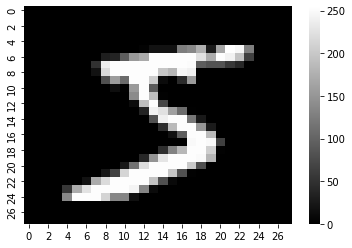

In [14]:
sns.heatmap(np.array(X_valid[0], dtype='float').reshape((28, 28)), cmap='gray')

In [13]:
def build_model(hp):
    model = keras.models.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28)))
    model.add(layers.BatchNormalization())
    for layer in range(hp.Int('num_layers', 1, 5)):
        model.add(
            layers.Dense(
                units=hp.Int(f'units_{layer}', min_value=32, max_value=512, step=32),
                activation='relu'
            )
        )
        model.add(layers.BatchNormalization())
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [16]:
# set the checkpoint and early stop
checkpoint = keras.callbacks.ModelCheckpoint('mnist_seq_model.h5', save_best_only=True)
earlystop = keras.callbacks.EarlyStopping(patience=5 , restore_best_weights=True)
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    overwrite=True
)
# find the possible best parameters
tuner.search(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[earlystop])

Trial 5 Complete [00h 06m 45s]
val_loss: 0.2192436316266656

Best val_loss So Far: 0.17991300321519374
Total elapsed time: 00h 46m 10s
INFO:tensorflow:Oracle triggered exit


In [17]:
model = tuner.get_best_models()[0]

In [18]:
model.summary()
model.save('mnist_seq_model.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 416)               13728     
_________________________________________________________________
batch_normalization_2 (Batch (None, 416)               1664      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1

In [15]:
model = keras.models.load_model('mnist_seq_model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [16]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 3s 273us/sample - loss: 0.1908 - acc: 0.9762


[0.1907691479101777, 0.9762]